In [70]:

    
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import gammaln
import dynesty
from dynesty import utils as dyfunc
import corner

# --- Default Prior Object -------------------------------------------
class UniformLogTrapezoidPrior:
    def __init__(self):
        """
        Default prior on 4 parameters:
          - 'log10F0':  Uniform in log10F0 over [-13, -7]
          - 'alpha':    trap: α ~ Uniform[ -2β ln(500), 4 - 2β ln(0.5) ]
          - 'beta':     log Uniform in beta over [1e-6, 5]
          - 'dif':      linear Uniform in δ_diff over [0.5, 1.5]
        """
        self.priors = {
            'log10F0':  {'type': 'linear', 'lo': -13, 'hi': -7},
            'beta':     {'type': 'log',    'lo': 1e-6, 'hi': 5},
            'alpha':    {'type': 'trap'},  # bounds computed conditionally on beta
            'dif':      {'type': 'linear', 'lo': 0.5, 'hi': 1.5}
        }
        self.ndim = 4
        # Order: [log10F0, alpha, beta, dif]
        self.names = ['log10F0', 'alpha', 'beta', 'dif']

    def transformcube(self, cube, inplace=True):
        """
        Transform a cube of Uniform[0,1] variables (length 4) into physical parameter values.
        The order is: [log10F0, alpha, beta, dif].
        Note: log10F0 is kept in log-space.
        """
        if not inplace:
            cube = np.copy(cube)
        # Transform log10F0: simply linear between lo and hi.
        lo, hi = self.priors['log10F0']['lo'], self.priors['log10F0']['hi']
        cube[0] = lo + cube[0] * (hi - lo)
        # Transform beta: log-uniform.
        lo_b, hi_b  = self.priors['beta']['lo'], self.priors['beta']['hi']
        log_beta    = math.log(lo_b) + cube[2] * (math.log(hi_b) - math.log(lo_b))
        cube[2]     = math.exp(log_beta)
        # Transform alpha: depends on beta.
        beta_val    = cube[2]
        lower_alpha = -2 * beta_val * math.log(500)
        upper_alpha = 4 - 2 * beta_val * math.log(0.5)
        cube[1] = lower_alpha + cube[1] * (upper_alpha - lower_alpha)
        # Transform dif: linear.
        lo_d, hi_d = self.priors['dif']['lo'], self.priors['dif']['hi']
        cube[3] = lo_d + cube[3] * (hi_d - lo_d)
        return cube

    def density(self, params):
        """
        Compute the prior density at a given 4D parameter vector.
        Here, params = [log10F0, alpha, beta, dif].
        """
        log10F0, alpha, beta, dif = params
        dens = 1.0
        # Density for log10F0 is uniform.
        dens *= 1.0 / (self.priors['log10F0']['hi'] - self.priors['log10F0']['lo'])
        # Density for beta (log-uniform).
        dens *= 1.0 / (beta * (math.log(self.priors['beta']['hi'] / self.priors['beta']['lo'])))
        # Density for alpha: uniform between bounds depending on beta.
        lower_alpha = -2 * beta * math.log(500)
        upper_alpha = 4 - 2 * beta * math.log(0.5)
        dens *= 1.0 / (upper_alpha - lower_alpha)
        # Density for dif (linear Uniform).
        dens *= 1.0 / (self.priors['dif']['hi'] - self.priors['dif']['lo'])
        return dens

# --- Empirical Prior Class -------------------------------------------

class EmpiricalPrior:
    def __init__(self, roi_data, energy_bins, n_subregions=100, radius=10,
                 T_iso=None, T_diff=None, template_shape=(400,400,30),
                 likelihood_func=None, prior_obj=None):
        """
        Parameters
        ----------
        roi_data : 3D numpy array
            ROI data with shape (n, n, n_energy)
        energy_bins : 1D numpy array
            Energy bin centers.
        n_subregions : int, optional
            Total number of sub-regions. (Will be arranged in a uniform grid.)
        radius : int or float, optional
            Radius (in pixels) of each sub-region.
        T_iso : numpy array or str, optional
            Isotropic template. If a string, assumed to be a file path to a binary file 
            containing 8-byte doubles in C-order.
        T_diff : numpy array or str, optional
            Diffuse template. Same as T_iso.
        template_shape : tuple, optional
            Shape to which to reshape the binary template file. Default is (400,400,30).
        likelihood_func : function, optional
            Function f(sub_data, phi, energy_bins) returning log-likelihood.
            Default is the Poisson likelihood defined below.
        prior_obj : object, optional
            Prior object with methods transformcube(cube) and density(params).
            If None, a default UniformLogTrapezoidPrior is used.
        """
        self.roi_data = roi_data
        self.energy_bins = energy_bins
        self.n_subregions = n_subregions
        self.radius = radius
        self.n = roi_data.shape[0]  # assume square
        
        # Process templates: if T_iso or T_diff are strings, read as binary files.
        self.T_iso = self._load_template(T_iso, template_shape) if T_iso is not None else np.zeros_like(energy_bins)
        self.T_diff = self._load_template(T_diff, template_shape) if T_diff is not None else np.zeros_like(energy_bins)
        
        self._generate_subregions()

        if likelihood_func is None:
            self.likelihood_func = self.default_log_likelihood
        else:
            self.likelihood_func = likelihood_func

        if prior_obj is None:
            self.prior_obj = UniformLogTrapezoidPrior()
        else:
            self.prior_obj = prior_obj

    def _load_template(self, T, template_shape):
        """
        If T is a string (file path), load the binary template.
        The file is assumed to contain 8-byte doubles stored in C-order.
        The data are reshaped to template_shape and then averaged over the spatial dimensions (axes 0 and 1).
        """
        if isinstance(T, str):
            data = np.fromfile(T, dtype=np.float64)
            if data.size != np.prod(template_shape):
                raise ValueError(f"File {T} does not have the expected number of elements.")
            data = data.reshape(template_shape, order='C')
            return data
        else:
            return T

    def _generate_subregions(self):
        """
        Generate sub-region centers uniformly on a grid over the ROI.
        If n_subregions is not a perfect square, use the largest perfect square <= n_subregions.
        """
        m = int(np.floor(np.sqrt(self.n_subregions)))
        total = m*m
        if total != self.n_subregions:
            print(f"Warning: n_subregions={self.n_subregions} is not a perfect square. Using {total} subregions.")
        margin = self.radius
        x_coords = np.linspace(margin, self.n - margin, m)
        y_coords = np.linspace(margin, self.n - margin, m)
        xv, yv = np.meshgrid(x_coords, y_coords)
        centers = np.vstack([xv.ravel(), yv.ravel()]).T
        self.subregion_centers = [tuple(center) for center in centers]

    def _extract_subregion(self, center):
        """Extract ROI data for a circular sub-region (all energy bins)."""
        x0, y0 = center
        y_idx, x_idx = np.ogrid[:self.n, :self.n]
        mask = (x_idx - x0)**2 + (y_idx - y0)**2 <= self.radius**2
        return self.roi_data[mask, :]

    def default_log_likelihood(self, sub_data, phi, energy_bins):
        """
        Default Poisson log-likelihood for the background model.
        
        Model:
          dΦ_bkg/dE/dΩ = T_iso(E) + δ_diff*T_diff(E) + dF/dE,
        with point-source spectrum:
          dF/dE = F0 (E/E0)^(-α - β log(E/E0)),  where F0 = 10^(log10F0) and E0=1 GeV.
        
        Expected counts in energy bin j (for a sub-region with A pixels):
          λ_j = A * [ T_iso(E_j) + δ_diff*T_diff(E_j) + dF/dE(E_j) ].
        """
        log10F0, alpha, beta, delta_diff = phi
        F0 = 10 ** (log10F0)
        A = sub_data.shape[0]
        n_counts = np.sum(sub_data, axis=0)
        E0 = 1.0
        dF_dE = F0 * (energy_bins / E0) ** (-alpha - beta * np.log(energy_bins / E0))
        lambda_j = A * (self.T_iso + delta_diff * self.T_diff + dF_dE)
        logL = np.sum(n_counts * np.log(lambda_j) - lambda_j - gammaln(n_counts + 1))
        return logL

    def plot_subregions(self):
        """
        Plot the ROI (using the first energy bin) and overlay the circular sub-regions.
        """
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(self.roi_data[:, :, 0], origin='lower', cmap='viridis')
        for center in self.subregion_centers:
            circle = plt.Circle(center, self.radius, color='red', fill=False, lw=1.5)
            ax.add_patch(circle)
        ax.set_title("ROI (first energy bin) with Overlapping Circular Sub-regions")
        plt.show()

    def calculate_subregion_posteriors_dynesty(self, nlive=500, sample='auto', rstate=None):
        """
        Use dynesty to sample the posterior over the 4D parameter space for each sub-region.
        The parameter vector is [log10F0, α, β, δ_diff].
        
        Returns
        -------
        subregion_samples : list of arrays
            Each element is an array of shape (N_samples, 4).
        """
        subregion_samples = []
        ndim = self.prior_obj.ndim

        for center in self.subregion_centers:
            sub_data = self._extract_subregion(center)

            def log_likelihood(theta):
                if theta[2] <= 0 or theta[3] <= 0:
                    return -np.inf
                return self.likelihood_func(sub_data, theta, self.energy_bins)

            def prior_transform(u):
                cube = np.array(u, copy=True)
                self.prior_obj.transformcube(cube, inplace=True)
                return cube.tolist()

            sampler = dynesty.NestedSampler(log_likelihood, prior_transform, ndim=ndim,
                                            nlive=nlive, sample=sample, rstate=rstate)
            sampler.run_nested()
            results = sampler.results
            samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
            samples_equal = dyfunc.resample_equal(samples, weights)
            subregion_samples.append(samples_equal)
        return subregion_samples


##############################################################################

##############################################################################
# Use Carina II for now
def read_array_from_file_2d_dp(filename, shape):
    """
    Read in a 2D/3D array from a file.
    The file is expected to contain 8-byte doubles stored in binary (C-order).
    The `shape` should be provided as a tuple (rows, columns, energy_bins) to correctly reshape the array.
    """
    with open(filename, 'rb') as file:
        data = np.fromfile(file, dtype=np.float64)
        array = data.reshape(shape)
    return array

# File paths (update these paths as needed)
filename          = './Data/Car2/obsdata.dat'
exposure_filename = './Data/Car2/expcube.dat'
# The shape of the ROI data array: e.g. 400 x 400 pixels and 30 energy bins.
shape = (400, 400, 30)

# Read the ROI data and the exposure cube.
roi_raw       = read_array_from_file_2d_dp(filename, shape)
exposure_cube = read_array_from_file_2d_dp(exposure_filename, shape)

# Correct the ROI data by dividing by the exposure cube.
roi_data = roi_raw / exposure_cube

# Define the energy bins. In the configuration these are 30 log-spaced bins between 0.5 and 500 GeV.
n_energy = shape[2]
energy_bins = np.logspace(np.log10(0.5), np.log10(500), n_energy)

# Now `roi_data` (shape: 400 x 400 x 30) and `energy_bins` are ready to be passed into the EMP prior class.
print("ROI data shape:", roi_data.shape)
print("Energy bins:", energy_bins)


ROI data shape: (400, 400, 30)
Energy bins: [  0.5          0.6344805    0.80513101   1.02167986   1.2964719
   1.64517228   2.08765947   2.64915845   3.36167877   4.26583926
   5.41318367   6.86911898   8.71664411  11.06108146  14.03608102
  17.81123945  22.60176828  28.68076255  36.39476922  46.18354286
  58.60511488  74.36760536  94.36959111 119.751331   151.95976912
 192.83102106 244.69504592 310.50847095 394.02314078 500.        ]


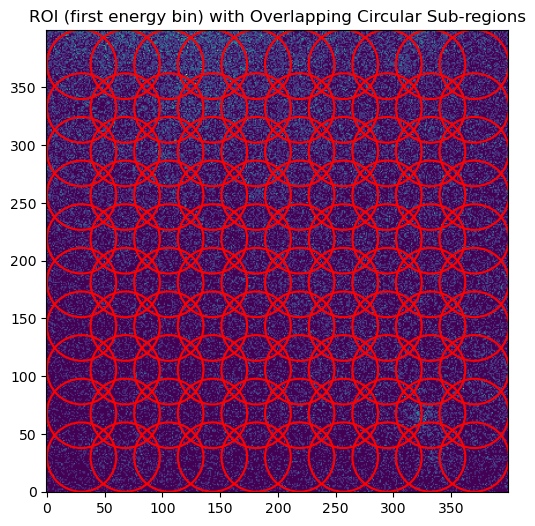

484it [00:34, 12.66it/s, bound: 0 | nc: 3 | ncall: 1275 | eff(%): 37.961 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.509]Traceback (most recent call last):
  File "/Users/andrescaffidi/miniconda/envs/lab/lib/python3.10/site-packages/dynesty/dynesty.py", line 910, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
  File "/var/folders/by/_81hyf914d3fm9smyq7spr6h0000gn/T/ipykernel_79665/605751087.py", line 217, in log_likelihood
    return self.likelihood_func(sub_data, theta, self.energy_bins)
  File "/var/folders/by/_81hyf914d3fm9smyq7spr6h0000gn/T/ipykernel_79665/605751087.py", line 183, in default_log_likelihood
    logL = np.sum(n_counts * np.log(lambda_j) - lambda_j - gammaln(n_counts + 1))
KeyboardInterrupt
484it [00:34, 14.16it/s, bound: 0 | nc: 3 | ncall: 1275 | eff(%): 37.961 | loglstar:   -inf <   -inf <    inf | logz:   -inf +/-    nan | dlogz:    inf >  0.509]

Exception while calling loglikelihood function:
  params: [-8.25883584e+00  1.21527440e+00  2.77763359e-06  1.01405541e+00]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [71]:
# Run!
if __name__ == "__main__":
    energy_bins = np.array([
    5.610092271509818e-01, 7.062687723113772e-01, 8.891397050194615e-01, 1.119360569284170e+00,
    1.409191465632227e+00, 1.774066946167878e+00, 2.233417960754816e+00, 2.811706625951746e+00,
    3.539728921920690e+00, 4.456254690668728e+00, 5.610092271509817e+00, 7.062687723113773e+00,
    8.891397050194616e+00, 1.119360569284170e+01, 1.409191465632227e+01, 1.774066946167877e+01,
    2.233417960754816e+01, 2.811706625951746e+01, 3.539728921920690e+01, 4.456254690668728e+01,
    5.610092271509817e+01, 7.062687723113773e+01, 8.891397050194617e+01, 1.119360569284170e+02,
    1.409191465632227e+02, 1.774066946167877e+02, 2.233417960754816e+02, 2.811706625951746e+02,
    3.539728921920692e+02, 4.456254690668729e+02
])
    n_energy = len(energy_bins)
    
    # Initialize the EMP prior object with the default prior.
    # Initialize the EMP prior object with the default prior.
    template_shape=(400, 400, 30)
    emp_prior_obj = EmpiricalPrior(roi_data, energy_bins, n_subregions=100, radius=30,
                                   T_iso="Data/Car2/bgtemplate_iso.dat", T_diff="Data/Car2/bgtemplate_diffuse.dat",
                                   template_shape=template_shape, prior_obj=None)
    
    # Visualize the sub-regions.
    emp_prior_obj.plot_subregions()
    
    # Run dynesty to sample sub-region posteriors.
    subregion_samples = emp_prior_obj.calculate_subregion_posteriors_dynesty(nlive=500, sample='auto')
    
    # Combine samples from all sub-regions.
    all_samples = np.vstack(subregion_samples)
    
    # Plot a corner plot of the empirical prior.
    try:
        import corner
        labels = [r"$F_0$", r"$\alpha$", r"$\beta$", r"$\delta_{\rm diff}$"]
        fig = corner.corner(all_samples, labels=labels, show_titles=True, title_fmt=".2e")
        
        # Set the xscale of the beta plot to log
        axes = np.array(fig.axes).reshape((4, 4))
        axes[2, 2].set_xscale('log')
        
        plt.show()
    except ImportError:
        print("Please install the 'corner' package to display the corner plot.")


In [ ]:
# Just plot
try:
    import corner
    labels = [r"$F_0$", r"$\alpha$", r"$\beta$", r"$\delta_{\rm diff}$"]
    fig = corner.corner(all_samples, labels=labels, show_titles=True, title_fmt=".2e")
    
    # Set the xscale of the beta plot to log
    axes = np.array(fig.axes).reshape((4, 4))
    axes[2, 2].set_xscale('log')
    
    plt.show()
except ImportError:
    print("Please install the 'corner' package to display the corner plot.")

## Plot Carina 2


/var/folders/by/_81hyf914d3fm9smyq7spr6h0000gn/T/ipykernel_65401/3443432557.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


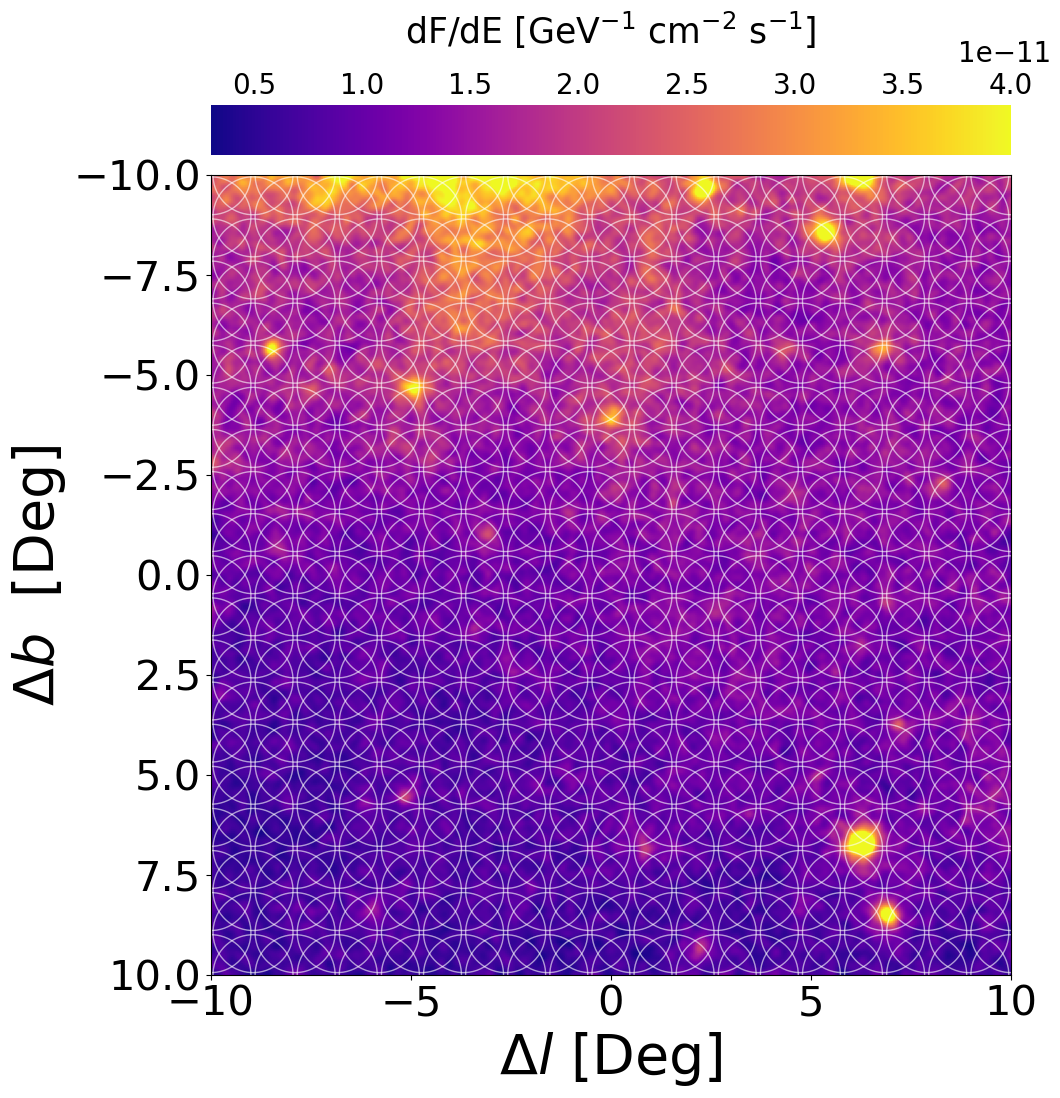

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.ndimage import gaussian_filter
from matplotlib.patches import Circle

def read_array_from_file_2d_dp(filename, shape):
    """
    Read in a 2D array from a file.
    The file is expected to contain 8-byte doubles stored in binary and in C-order (last index runs fastest).
    The `shape` should be provided as a tuple (rows, columns) to correctly reshape the array.
    """
    # Open the file in binary read mode
    with open(filename, 'rb') as file:
        # Read the entire file into a 1D array of doubles
        data = np.fromfile(file, dtype=np.float64)
        
        # Reshape the array to the specified 2D shape (rows, columns)
        array = data.reshape(shape)
    
    return array
# Read your data as before
filename = './Data/Car2/obsdata.dat'
exposure_filename = './Data/Car2/expcube.dat'
shape = (400, 400, 30)
array = read_array_from_file_2d_dp(filename, shape)
arrayexp = read_array_from_file_2d_dp(exposure_filename, shape)
array = array / arrayexp

# Process your data as before
map1 = array
map1_sum = np.sum(map1, axis=2)
map2 = array
map2_sum = np.sum(map2, axis=2)
map2_sum += map1_sum
sigma = 1.8
map2_sum_smoothed = gaussian_filter(map2_sum, sigma=sigma)
vmin, vmax = (0.03E-10, .4E-10)
extent = [-10, 10, -10, 10]

# Create a figure and define axes positions explicitly
fig = plt.figure(figsize=(20, 10))

# Define positions and sizes
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8  # Main plot dimensions
cbar_height = 0.05  # Height of the colorbar
spacing = 0.02      # Vertical space between colorbar and main plot

# Adjust colorbar width to be less than main plot width
cbar_width = width * 0.5    # Colorbar is 60% of main plot width
cbar_left = left + (width - cbar_width) / 2  # Centered over main plot

# Main plot axis
axs = fig.add_axes([left, bottom, width, height])

# Colorbar axis positioned on top of the main plot
ax_colorbar = fig.add_axes([cbar_left, bottom + height + spacing, cbar_width, cbar_height])

# Display the 2D array
im2 = axs.imshow(map2_sum_smoothed, vmin=vmin, vmax=vmax, cmap='plasma', extent=extent)

# Invert the y-axis
axs.invert_yaxis()

# Add circles to represent the sub-regions
n_grid = 20
x_min, x_max = -10, 10
y_min, y_max = -10, 10
x_coords = np.linspace(x_min, x_max, n_grid)
y_coords = np.linspace(y_min, y_max, n_grid)
radius = 1.0
for x in x_coords:
    for y in y_coords:
        circle = Circle((x, y), radius=radius, color='white', alpha=0.6, fill=False)
        axs.add_patch(circle)

# Add a colorbar on top with reduced width
cbar = fig.colorbar(im2, cax=ax_colorbar, orientation='horizontal',
                    label=r'dF/dE [GeV$^{-1}$ cm$^{-2}$ s$^{-1}$]')

# Adjust colorbar label and ticks
cbar.ax.xaxis.set_ticks_position('top')
cbar.ax.xaxis.set_label_position('top')
cbar.ax.xaxis.labelpad = 20
cbar.ax.xaxis.label.set_size(25)
cbar.ax.tick_params(labelsize=20)
cbar.ax.xaxis.get_offset_text().set_fontsize(20)

offset_text = cbar.ax.xaxis.get_offset_text()
offset_text.set_fontsize(20)

offset_text.set_x(offset_text.get_position()[0] + 0.05)
offset_text.set_y(offset_text.get_position()[1] + 0.01)
# Remove ticks and frame from colorbar axis (since the colorbar handles them)
ax_colorbar.tick_params(axis='both', which='both', length=0)
# ax_colorbar.set_xticks([])
# ax_colorbar.set_yticks([])
for spine in ax_colorbar.spines.values():
    spine.set_visible(False)

# Adjust the main plot labels and ticks
axs.set_xlabel(r'$\Delta l$ [Deg]', fontsize=40)
axs.set_ylabel(r'$\Delta b$  [Deg]', fontsize=40)
axs.tick_params(axis='both', which='major', labelsize=30)
# Save and show the figure
plt.tight_layout()
plt.show()

In [18]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.special import gammaln
import dynesty
from dynesty import utils as dyfunc
import corner

# --- Default Prior Object -------------------------------------------
class UniformLogTrapezoidPrior:
    def __init__(self):
        """
        Default prior on 4 parameters:
          - 'log10F0':  Uniform in log10F0 over [-13, -7]
          - 'alpha':    trap: α ~ Uniform[ -2β ln(500), 4 - 2β ln(0.5) ]
          - 'beta':     log Uniform in beta over [1e-6, 5]
          - 'dif':      linear Uniform in δ_diff over [0.5, 1.5]
        """
        self.priors = {
            'log10F0':  {'type': 'linear', 'lo': -13, 'hi': -7},
            'beta':     {'type': 'log',    'lo': 1e-6, 'hi': 5},
            'alpha':    {'type': 'trap'},  # bounds computed conditionally on beta
            'dif':      {'type': 'linear', 'lo': 0.5, 'hi': 1.5}
        }
        self.ndim = 4
        # Order: [log10F0, alpha, beta, dif]
        self.names = ['log10F0', 'alpha', 'beta', 'dif']

    def transformcube(self, cube, inplace=True):
        """
        Transform a cube of Uniform[0,1] variables (length 4) into physical parameter values.
        The order is: [log10F0, alpha, beta, dif].
        Note: log10F0 is kept in log-space.
        """
        if not inplace:
            cube = np.copy(cube)
        # Transform log10F0: simply linear between lo and hi.
        lo, hi = self.priors['log10F0']['lo'], self.priors['log10F0']['hi']
        cube[0] = lo + cube[0] * (hi - lo)
        # Transform beta: log-uniform.
        lo_b, hi_b = self.priors['beta']['lo'], self.priors['beta']['hi']
        log_beta = math.log(lo_b) + cube[2] * (math.log(hi_b) - math.log(lo_b))
        cube[2] = math.exp(log_beta)
        # Transform alpha: depends on beta.
        beta_val = cube[2]
        lower_alpha = -2 * beta_val * math.log(500)
        upper_alpha = 4 - 2 * beta_val * math.log(0.5)
        cube[1] = lower_alpha + cube[1] * (upper_alpha - lower_alpha)
        # Transform dif: linear.
        lo_d, hi_d = self.priors['dif']['lo'], self.priors['dif']['hi']
        cube[3] = lo_d + cube[3] * (hi_d - lo_d)
        return cube

    def density(self, params):
        """
        Compute the prior density at a given 4D parameter vector.
        Here, params = [log10F0, alpha, beta, dif].
        """
        log10F0, alpha, beta, dif = params
        dens = 1.0
        # Density for log10F0 is uniform.
        dens *= 1.0 / (self.priors['log10F0']['hi'] - self.priors['log10F0']['lo'])
        # Density for beta (log-uniform).
        dens *= 1.0 / (beta * (math.log(self.priors['beta']['hi'] / self.priors['beta']['lo'])))
        # Density for alpha: uniform between bounds depending on beta.
        lower_alpha = -2 * beta * math.log(500)
        upper_alpha = 4 - 2 * beta * math.log(0.5)
        dens *= 1.0 / (upper_alpha - lower_alpha)
        # Density for dif (linear Uniform).
        dens *= 1.0 / (self.priors['dif']['hi'] - self.priors['dif']['lo'])
        return dens

# --- Empirical Prior Class -------------------------------------------
class EmpiricalPrior:
    def __init__(self, roi_data, energy_bins, n_subregions=10, radius=10,
                 T_iso=None, T_diff=None,
                 likelihood_func=None, prior_obj=None):
        """
        Parameters
        ----------
        roi_data : 3D numpy array
            ROI data with shape (n, n, n_energy).
        energy_bins : 1D numpy array
            Energy bin centers.
        n_subregions : int, optional
            Number of circular sub-regions.
        radius : int or float, optional
            Radius (in pixels) of each sub-region.
        T_iso : numpy array or str, optional
            Isotropic template. If a string, assumed to be a file path.
        T_diff : numpy array or str, optional
            Diffuse template. Same as T_iso.
        likelihood_func : function, optional
            Function f(sub_data, phi, energy_bins) returning log-likelihood.
            Default is the Poisson likelihood defined below.
        prior_obj : object, optional
            Prior object with methods transformcube(cube) and density(params).
            If None, a default UniformLogTrapezoidPrior is used.
        """
        self.roi_data = roi_data
        self.energy_bins = energy_bins
        self.n_subregions = n_subregions
        self.radius = radius
        self.n = roi_data.shape[0]  # assume square
        
        # Process templates.
        self.T_iso = self._load_template(T_iso) if T_iso is not None else np.zeros_like(energy_bins)
        self.T_diff = self._load_template(T_diff) if T_diff is not None else np.zeros_like(energy_bins)
        
        self._generate_subregions()

        if likelihood_func is None:
            self.likelihood_func = self.default_log_likelihood
        else:
            self.likelihood_func = likelihood_func

        if prior_obj is None:
            self.prior_obj = UniformLogTrapezoidPrior()
        else:
            self.prior_obj = prior_obj

    def _load_template(self, T, template_shape=(400, 400, 30)):
        """
        If T is a string (file path), load the template, reshape it, and average over spatial dimensions.
        Otherwise, assume T is already an array with the energy axis last.
        """
        if isinstance(T, str):
            data = np.genfromtxt(T, delimiter=',', comments='!')
            data = data.reshape(template_shape)
            return np.mean(data, axis=(0,1))
        else:
            return T

    def _generate_subregions(self):
        """Generate random circular sub-region centers."""
        margin = self.radius
        self.subregion_centers = []
        for _ in range(self.n_subregions):
            x = np.random.randint(margin, self.n - margin)
            y = np.random.randint(margin, self.n - margin)
            self.subregion_centers.append((x, y))

    def _extract_subregion(self, center):
        """Extract ROI data for a circular sub-region (all energy bins)."""
        x0, y0 = center
        y_idx, x_idx = np.ogrid[:self.n, :self.n]
        mask = (x_idx - x0)**2 + (y_idx - y0)**2 <= self.radius**2
        return self.roi_data[mask, :]

    def default_log_likelihood(self, sub_data, phi, energy_bins):
        """
        Default Poisson log-likelihood for the background model.
        
        Model:
          dΦ_bkg/dE/dΩ = T_iso(E) + δ_diff*T_diff(E) + dF/dE,
        with point-source spectrum given by a log–parabola:
          dF/dE = F0 (E/E0)^(-α - β log(E/E0)),  E0=1 GeV.
        
        Note: Here phi[0] is log10F0. We convert it to F0.
        
        Expected counts in energy bin j for a sub-region with A pixels:
          λ_j = A * [ T_iso(E_j) + δ_diff*T_diff(E_j) + dF/dE(E_j) ],
        where dF/dE(E_j) = F0 (E_j/E0)^(-α - β log(E_j/E0)).
        """
        log10F0, alpha, beta, delta_diff = phi
        # Convert log10F0 to F0.
        F0 = 10 ** (log10F0)
        A = sub_data.shape[0]
        n_counts = np.sum(sub_data, axis=0)
        E0 = 1.0
        # Compute dF/dE using F0 (not log10F0).
        dF_dE = F0 * (energy_bins / E0) ** (-alpha - beta * np.log(energy_bins / E0))
        lambda_j = A * (self.T_iso + delta_diff * self.T_diff + dF_dE)
        logL = np.sum(n_counts * np.log(lambda_j) - lambda_j - gammaln(n_counts + 1))
        return logL

    def calculate_subregion_posteriors_dynesty(self, nlive=500, sample='auto', rstate=None):
        """
        Use dynesty to sample the posterior over the 4D parameter space for each sub-region.
        The prior transform uses the provided prior object.
        
        Returns
        -------
        subregion_samples : list of arrays
            Each element is an array of shape (N_samples, 4) with parameters [log10F0, α, β, δ_diff].
        """
        subregion_samples = []
        ndim = self.prior_obj.ndim

        for center in self.subregion_centers:
            sub_data = self._extract_subregion(center)

            def log_likelihood(theta):
                # Enforce positivity for beta and δ_diff.
                if theta[2] <= 0 or theta[3] <= 0:
                    return -np.inf
                return self.likelihood_func(sub_data, theta, self.energy_bins)

            def prior_transform(u):
                cube = np.array(u, copy=True)
                self.prior_obj.transformcube(cube, inplace=True)
                return cube.tolist()

            sampler = dynesty.NestedSampler(log_likelihood, prior_transform, ndim=ndim,
                                            nlive=nlive, sample=sample, rstate=rstate)
            sampler.run_nested()
            results = sampler.results
            samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
            samples_equal = dyfunc.resample_equal(samples, weights)
            subregion_samples.append(samples_equal)
        return subregion_samples

# --- Example Usage --------------------------------------------------
if __name__ == "__main__":
    # Simulate ROI data with shape (400,400,30) and define energy bins.
    n_spatial = 400
    n_energy = 30
    roi_data = np.random.poisson(lam=5, size=(n_spatial, n_spatial, n_energy))
    energy_bins = np.logspace(np.log10(0.5), np.log10(500), n_energy)
    
    # Create dummy template files for demonstration.
    template_shape = (400, 400, n_energy)
    dummy_iso = np.full(np.prod(template_shape), 1e-7)
    dummy_diff = np.full(np.prod(template_shape), 1e-6)
    np.savetxt("bgtemplate_iso.dat", dummy_iso, delimiter=',')
    np.savetxt("bgtemplate_diffuse.dat", dummy_diff, delimiter=',')
    
    # Initialize the EMP prior object with default prior.
    emp_prior_obj = EmpiricalPrior(roi_data, energy_bins, n_subregions=20, radius=10,
                                   T_iso="bgtemplate_iso.dat", T_diff="bgtemplate_diffuse.dat",
                                   prior_obj=None)
    
    # Run dynesty to sample posteriors.
    subregion_samples = emp_prior_obj.calculate_subregion_posteriors_dynesty(nlive=500, sample='auto')
    
    # Combine samples from all sub-regions.
    all_samples = np.vstack(subregion_samples)
    
    # Produce a corner plot.
    labels = [r"$\log_{10}F_0$", r"$\alpha$", r"$\beta$", r"$\delta_{\rm diff}$"]
    fig = corner.corner(all_samples, labels=labels, show_titles=True, title_fmt=".2e")
    plt.show()


7758it [00:05, 1505.95it/s, bound: 33 | nc: 12 | ncall: 42810 | eff(%): 18.122 | loglstar:   -inf < -216828.254 <    inf | logz: -216849.298 +/-    nan | dlogz: 2110.784 >  0.509] 


KeyboardInterrupt: 